In [1]:
import os
# Check if the kaggle.json file is in the correct location
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d jeffheaton/demand-forecasting-with-tabular-textual-images

Dataset URL: https://www.kaggle.com/datasets/jeffheaton/demand-forecasting-with-tabular-textual-images
License(s): CC-BY-SA-4.0
 90% 113M/126M [00:00<00:00, 180MB/s] 
100% 126M/126M [00:00<00:00, 148MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/demand-forecasting-with-tabular-textual-images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import numpy as np
import pandas as pd

In [5]:
df_sales=pd.read_csv('/content/beach_demand_forecast/sales_train.csv')

In [6]:
df_restraunt=pd.read_csv('/content/beach_demand_forecast/resturants.csv')
df_items=pd.read_csv('/content/beach_demand_forecast/items.csv')

In [7]:
df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

In [8]:
df_sales['weekday'] = df_sales.date.dt.day_name()

In [9]:
start_date = df_sales.date.min()
df_sales['week'] = (((df_sales.date - start_date).dt.days) / 7).astype(int)

In [10]:
import plotly.express as px

df_plot = df_sales[['date','item_count']].groupby(['date']).sum().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='Total Sales by Date')
fig.show()

In [11]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Obtain data aggregated by weekday.
df_plot = df_sales[['weekday','item_count']].groupby(['weekday']).sum().reset_index()
# Sort by day of week
df_plot = df_plot.set_index("weekday").loc[day_order].reset_index()

fig = px.bar(df_plot, x='weekday', y='item_count', title='Total Sales by Day of Week')
fig.show()

In [12]:
df2 = df_sales[['item_id','item_count']].groupby(['item_id']).sum().reset_index().sort_values('item_count',ascending=False)
df_items2 = df_items[['id','name']]
df_items2.columns = ['item_id','name']
df_popular = df2.merge(df_items2)
print(df_popular.to_string())

    item_id  item_count                                                  name
0        19    236337.0                                    Strawberry Smoothy
1        16    102990.0                                  Frozen Milky Smoothy
2        76     61043.0                                    Amazing pork lunch
3        38     52772.0                                         Mutton Dinner
4         9     43874.0                                          Orange Juice
5        59     42774.0                               Blue Ribbon Beef Entree
6         4     34439.0                       Amazing Steak Dinner with Rolls
7        13     27490.0                               Sweet Frozen Soft Drink
8        56     23839.0                       Sea Bass with Vegetables Dinner
9        67     18764.0                                       Sweet Lamb Cake
10       21     13190.0                     Amazing Fish with Vegetables Meal
11       12      7791.0                                  Fantast

In [13]:
train_size = 0.7

# Calculate the index to split the data
split_index = int(len(df_sales) * train_size)

train_df = df_sales.iloc[:split_index].groupby('date')['item_count'].sum().reset_index()
test_df = df_sales.iloc[split_index:].groupby('date')['item_count'].sum().reset_index()

In [14]:
train_df.set_index('date', inplace=True)
train_df.index = pd.DatetimeIndex(train_df.index).to_period('D')
test_df.set_index('date', inplace=True)
test_df.index = pd.DatetimeIndex(test_df.index).to_period('D')

In [19]:
train_df = train_df.asfreq('D')

In [25]:
train_df = train_df.resample('D').mean()  # Resample to daily and take the mean
train_df['item_count'].interpolate(method='linear', inplace=True)  # Fill missing values

<ipython-input-25-d38c7408b07d>:1: FutureWarning:

Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.

<ipython-input-25-d38c7408b07d>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<ipython-input-31-37628c4b8c2e>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





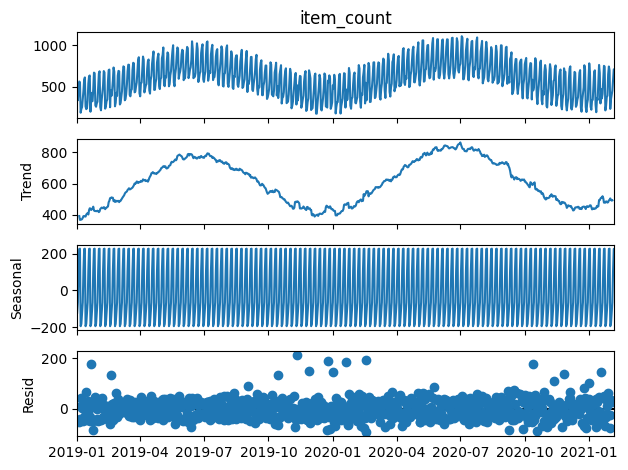

In [31]:
train_df = train_df.resample('D').mean()  # Resample to daily and take the mean
train_df['item_count'].interpolate(method='linear', inplace=True)  # Fill missing values

if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df.index = pd.to_datetime(train_df.index)

decomp = seasonal_decompose(train_df['item_count'], model='additive', period=7)
decomp.plot()
plt.show()  # Add plt.show() to display the plot

In [33]:
from sklearn.linear_model import LinearRegression

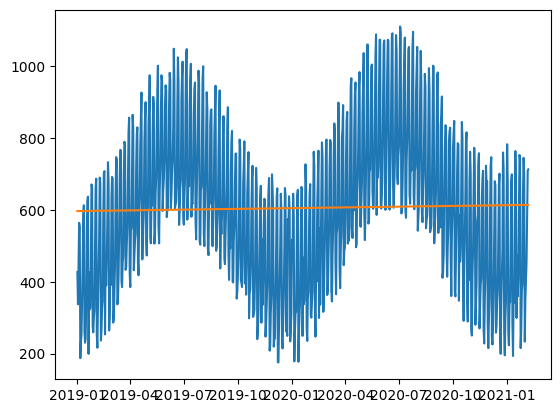

In [34]:
# Step 1: Detrending using linear regression
X = np.arange(len(train_df)).reshape(-1, 1)

trend_model = LinearRegression()
trend_model.fit(X, train_df['item_count'].values)

train_df['trend'] = trend_model.predict(X)
plt.plot(train_df['item_count'])
plt.plot(train_df['trend'])

In [35]:
train_df['detrend'] = train_df['item_count'] - train_df['trend']

In [36]:
train_df.index = pd.to_datetime(train_df.index)
seasonal_indices = train_df['detrend'].groupby(train_df.index.day_name()).mean()

In [37]:
seasonal_component_df = seasonal_indices.to_frame(name='weekly_seasonality')

In [38]:
seasonal_component_df

,weekly_seasonality
date,
Friday,223.884351
Monday,-180.670566
Saturday,225.652816
Sunday,-193.060966
Thursday,106.297704
Tuesday,-120.730136
Wednesday,-64.770762


In [39]:
train_df = train_df.merge(seasonal_component_df, left_on=train_df.index.day_name(), right_index=True)

In [40]:
train_df['with_yearly_seasonality'] = train_df['detrend'] - train_df['weekly_seasonality']

In [41]:
train_df.drop(columns=['key_0'], inplace=True)

In [42]:
seasonal_indices = train_df['with_yearly_seasonality'].groupby(train_df.index.month).mean()

In [43]:
yearly_seasonal_component_df = seasonal_indices.to_frame(name='yearly_seasonality')

In [44]:
train_df = train_df.merge(yearly_seasonal_component_df, left_on=train_df.index.month, right_index=True)

In [45]:
train_df

,key_0,item_count,trend,detrend,weekly_seasonality,with_yearly_seasonality,yearly_seasonality
date,,,,,,,
2019-01-01,1,427.0,596.776949,-169.776949,-120.730136,-49.046813,-165.871253
2019-01-02,1,337.0,596.799393,-259.799393,-64.770762,-195.028631,-165.871253
2019-01-03,1,445.0,596.821837,-151.821837,106.297704,-258.119540,-165.871253
2019-01-04,1,564.0,596.844280,-32.844280,223.884351,-256.728631,-165.871253
2019-01-05,1,552.0,596.866724,-44.866724,225.652816,-270.519540,-165.871253
...,...,...,...,...,...,...,...
2021-02-02,2,401.0,613.901505,-212.901505,-120.730136,-92.171369,-108.299263
2021-02-03,2,455.0,613.923949,-158.923949,-64.770762,-94.153187,-108.299263
2021-02-04,2,586.0,613.946393,-27.946393,106.297704,-134.244096,-108.299263


In [46]:
train_df['stationary'] = train_df['with_yearly_seasonality'] - train_df['yearly_seasonality']

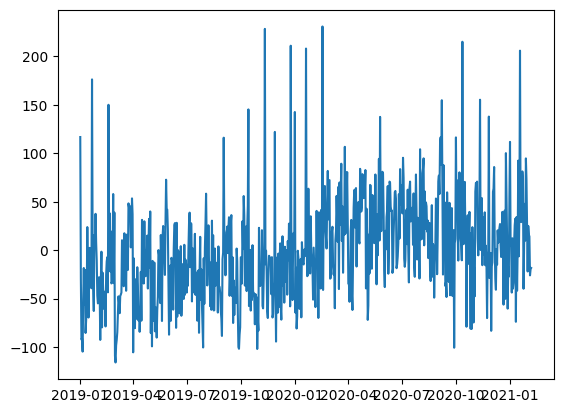

In [47]:
plt.plot(train_df['stationary'])

In [48]:
from statsmodels.tsa.stattools import adfuller

In [49]:
# ADF Test on Residuals
adf_result = adfuller(train_df['stationary'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -6.339728762209477
p-value: 2.7737775901228922e-08
Critical Values: {'1%': -3.4389722010249386, '5%': -2.8653454308425705, '10%': -2.5687964010457227}


In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'Partial Autocorrelation Function (ACF)')

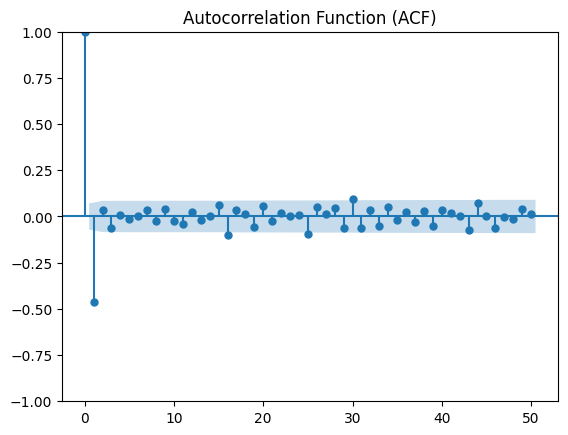

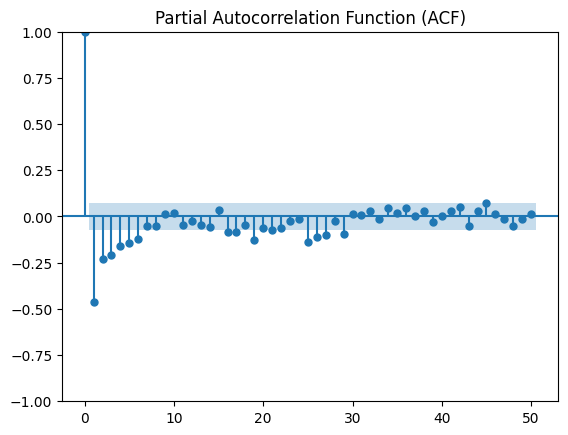

In [51]:
plot_acf(np.array(train_df['stationary'].diff().dropna()),lags=50)
plt.title('Autocorrelation Function (ACF)')

plot_pacf(np.array(train_df['stationary'].diff().dropna()),lags=50)
plt.title('Partial Autocorrelation Function (ACF)')

In [52]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00


In [53]:
import pmdarima as pm
from pmdarima import auto_arima

In [132]:
arima_model = auto_arima(train_df['stationary'], start_p=0, start_q=0, d=1, max_p=8, max_q=8,
                         D=1, max_order=None, m=7,start_P=0, start_Q=0, max_P=6, max_Q=6,
                         seasonal=True, information_criterion='aic',
                         alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True,
                         n_jobs=1, start_params=None, trend=None, method='lbfgs',
                         maxiter=50, offset_test_args=None, seasonal_test_args=None,
                         suppress_warnings=True, error_action='trace', trace=False,
                         random=False, random_state=None, n_fits=10,
                         return_valid_fits=False, out_of_sample_size=0,
                         scoring='mse', scoring_args=None, with_intercept='auto',
                         sarimax_kwargs=None)
arima_model.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

KeyboardInterrupt: 

In [55]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  768
Model:             SARIMAX(6, 1, 0)x(6, 1, 0, 7)   Log Likelihood               -4056.843
Date:                           Thu, 19 Dec 2024   AIC                           8139.686
Time:                                   16:41:46   BIC                           8199.919
Sample:                               01-01-2019   HQIC                          8162.880
                                    - 02-06-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8061      0.041    -19.604      0.000      -0.887      -0.725
ar.L2         -0.6654      0.052    -12.737      0.000      -0.768      -0.563
ar.L3         -0.5852      0.058    -10.042      0.000      -0.699      -0.471
ar.L4         -0.5086      0.066     -7.671      0.000      -0.639      -0.379
ar.L5         -0.4445      0.069     -6.409      0.000      -0.580      -0.309
ar.L6         -0.3706      0.072     -5.153      0.000      -0.512      -0.230
ar.S.L7       -1.1353      0.068    -16.585      0.000      -1.269      -1.001
ar.S.L14      -1.1101      0.103    -10.731      0.000      -1.313      -0.907
ar.S.L21      -0.9921      0.117     -8.495      0.000      -1.221      -0.763
ar.S.L28      -0.6429      0.108     -5.927      0.000      -0.855      -0.430
ar.S.L35      -0.3488      0.080     -4.377      0.000      -0.505      -0.193
ar.S.L42      -0.1726      0.048     -3.622      0.000      -0.266      -0.079
sigma2      2500.5116     92.275     27.099      0.000    2319.657    2681.366
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               192.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.57
Prob(H) (two-sided):                  0.20   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [69]:
train_df

,key_0,item_count,trend,detrend,weekly_seasonality,with_yearly_seasonality,yearly_seasonality,stationary
date,,,,,,,,
2019-01-01,1,427.0,596.776949,-169.776949,-120.730136,-49.046813,-165.871253,116.824440
2019-01-02,1,337.0,596.799393,-259.799393,-64.770762,-195.028631,-165.871253,-29.157378
2019-01-03,1,445.0,596.821837,-151.821837,106.297704,-258.119540,-165.871253,-92.248287
2019-01-04,1,564.0,596.844280,-32.844280,223.884351,-256.728631,-165.871253,-90.857378
2019-01-05,1,552.0,596.866724,-44.866724,225.652816,-270.519540,-165.871253,-104.648287
...,...,...,...,...,...,...,...,...
2021-02-02,2,401.0,613.901505,-212.901505,-120.730136,-92.171369,-108.299263,16.127894
2021-02-03,2,455.0,613.923949,-158.923949,-64.770762,-94.153187,-108.299263,14.146076
2021-02-04,2,586.0,613.946393,-27.946393,106.297704,-134.244096,-108.299263,-25.944834


In [173]:
model = SARIMAX(train_df['stationary'], order=(0, 1, 4), seasonal_order=(1, 1, 1, 7))

# Fit the model
results = model.fit()

In [174]:
forecast = results.forecast(steps=len(test_df))

In [175]:
train_df

,key_0,item_count,trend,detrend,weekly_seasonality,with_yearly_seasonality,yearly_seasonality,stationary
date,,,,,,,,
2019-01-01,1,427.0,596.776949,-169.776949,-120.730136,-49.046813,-165.871253,116.824440
2019-01-02,1,337.0,596.799393,-259.799393,-64.770762,-195.028631,-165.871253,-29.157378
2019-01-03,1,445.0,596.821837,-151.821837,106.297704,-258.119540,-165.871253,-92.248287
2019-01-04,1,564.0,596.844280,-32.844280,223.884351,-256.728631,-165.871253,-90.857378
2019-01-05,1,552.0,596.866724,-44.866724,225.652816,-270.519540,-165.871253,-104.648287
...,...,...,...,...,...,...,...,...
2021-02-02,2,401.0,613.901505,-212.901505,-120.730136,-92.171369,-108.299263,16.127894
2021-02-03,2,455.0,613.923949,-158.923949,-64.770762,-94.153187,-108.299263,14.146076
2021-02-04,2,586.0,613.946393,-27.946393,106.297704,-134.244096,-108.299263,-25.944834


In [176]:
test_df

,item_count
date,
2021-02-07,251.0
2021-02-08,266.0
2021-02-09,380.0
2021-02-10,412.0
2021-02-11,638.0
...,...
2021-12-27,192.0
2021-12-28,344.0
2021-12-29,371.0


In [177]:
forecast

,predicted_mean
2021-02-07,11.817207
2021-02-08,22.772379
2021-02-09,30.646829
2021-02-10,30.319211
2021-02-11,28.349870
...,...
2021-12-27,56.106297
2021-12-28,59.740497
2021-12-29,58.010996
2021-12-30,59.375234


In [178]:
# Get seasonality components
test_yearly_seasonality = test_df.merge(
    yearly_seasonal_component_df,
    left_on=test_df.index.month,
    right_index=True
)['yearly_seasonality']

test_weekly_seasonality = test_df.merge(
    seasonal_component_df,
    left_on=test_df.index.day_name(),
    right_index=True
)['weekly_seasonality']

# Calculate trend component
X_test = np.arange(len(train_df), len(train_df) + len(test_df)).reshape(-1, 1)
trend_test = trend_model.predict(X_test)

# Combine components
trend_seasonality = (
    test_yearly_seasonality +
    test_weekly_seasonality +
    trend_test
)

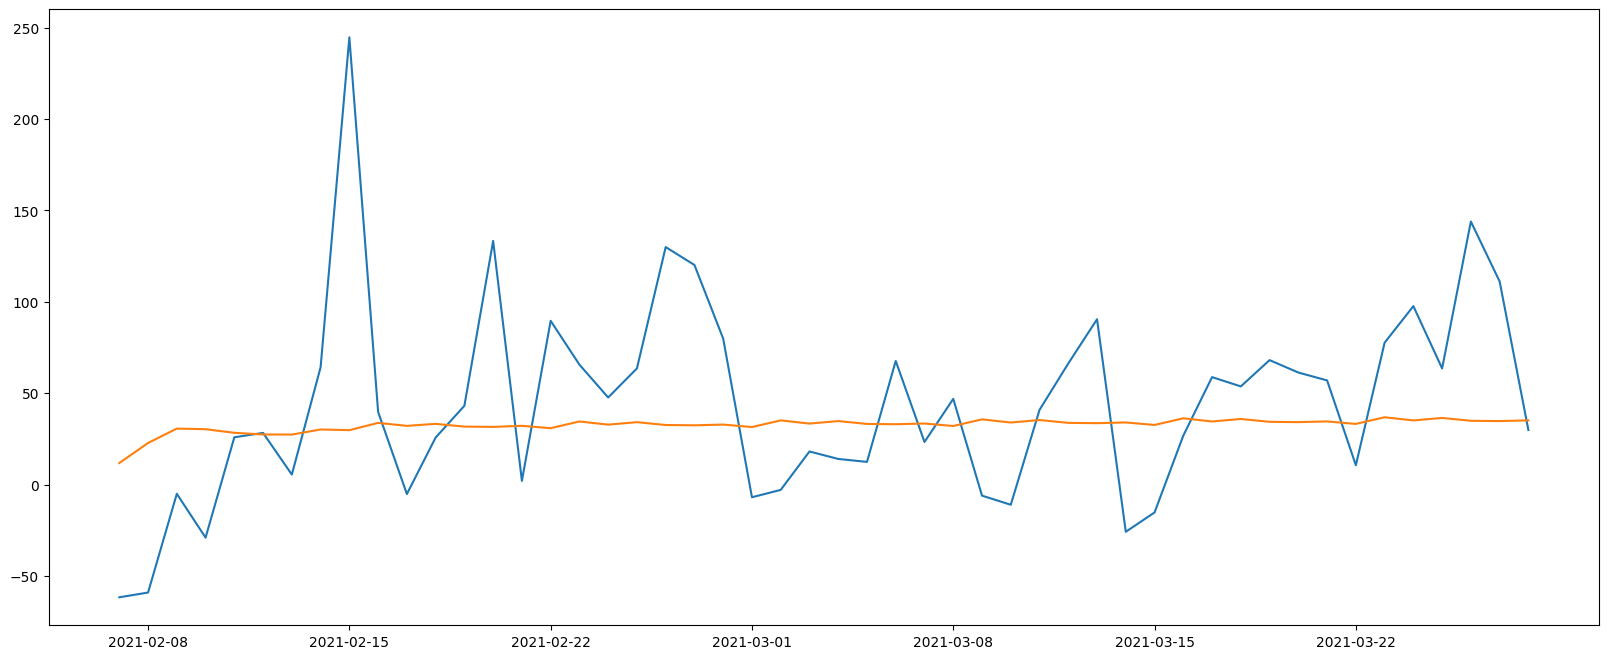

In [179]:
plt.figure(figsize=(20,8))
ac = test_df['item_count'] - trend_seasonality
plt.plot(ac[:50])
plt.plot(forecast[:50])

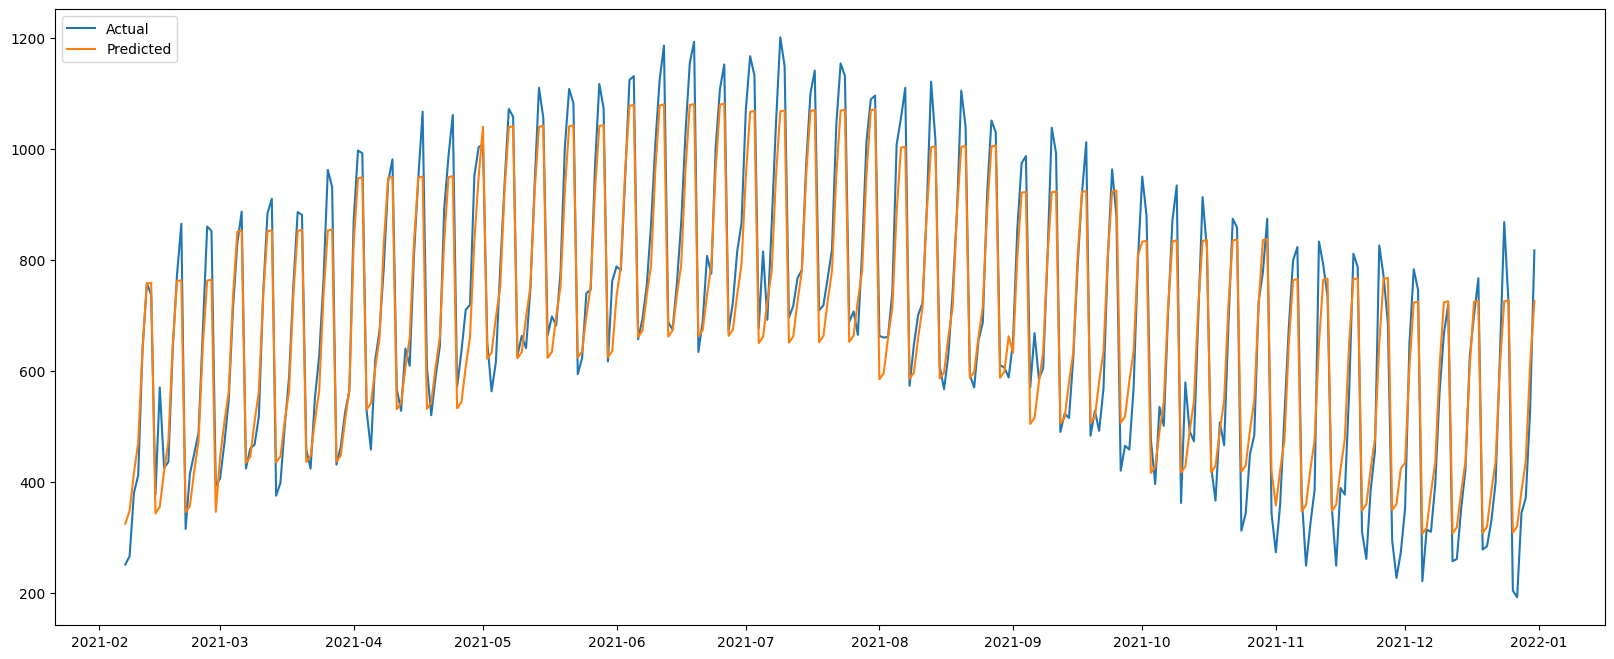

In [180]:
Y_hat = forecast + trend_seasonality
plt.figure(figsize=(20,8))
#plt.plot(train, label='Training')
plt.plot(test_df['item_count'],label='Actual')
plt.plot(Y_hat,label = 'Predicted')
plt.legend(loc = 'upper left')
plt.show()

In [181]:
from sklearn.metrics import mean_squared_error

In [182]:
len(test_df)

328

In [183]:
len(Y_hat)

328

In [184]:
# test_df.dropna(inplace=True)

In [191]:
train_df['stationary']

,stationary
date,
2019-01-01,116.824440
2019-01-02,-29.157378
2019-01-03,-92.248287
2019-01-04,-90.857378
2019-01-05,-104.648287
...,...
2021-02-02,16.127894
2021-02-03,14.146076
2021-02-04,-25.944834


In [193]:
# Ensure Y_hat and test_df have same length

# Calculate metrics
rmse_arima = np.sqrt(mean_squared_error(test_df['item_count'], Y_hat))
print(f"RMSE: {rmse_arima:.2f}")

mae_arima = np.mean(np.abs(test_df['item_count'] - Y_hat))
print(f"MAE: {mae_arima:.2f}")

mape_arima = np.mean(np.abs((test_df['item_count'] - Y_hat) / test_df['item_count'])) * 100
print(f"MAPE: {mape_arima:.2f}%")

RMSE: 60.72
MAE: 48.33
MAPE: 8.38%


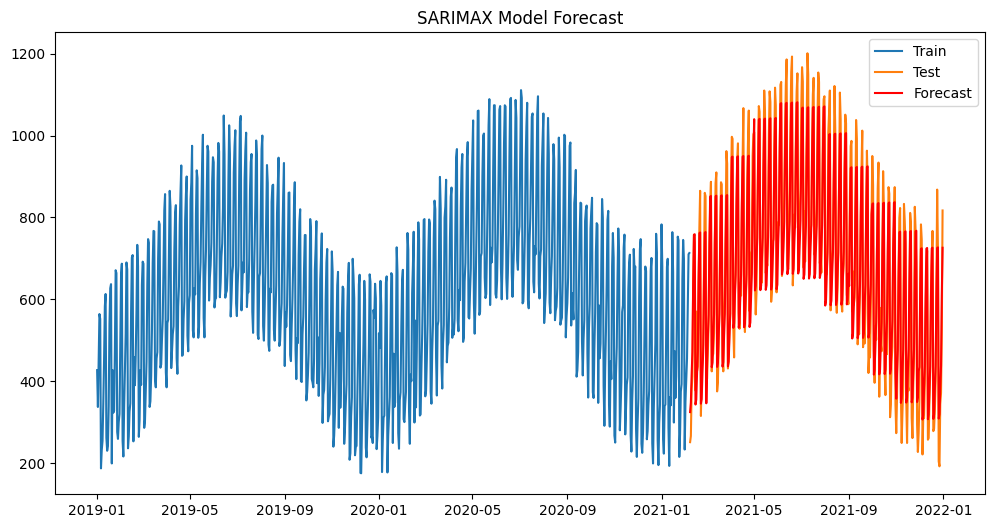

In [194]:

plt.figure(figsize=(12, 6))
plt.plot(train_df['item_count'], label='Train')
plt.plot(test_df['item_count'], label='Test')
plt.plot(Y_hat, label='Forecast', color='red')
plt.legend()
plt.title('SARIMAX Model Forecast')
plt.show()